<a href="https://colab.research.google.com/github/stavco9/neuralnetworks-final-project/blob/main/1.%20CNN%20Model%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model Notebook

This notebook handles the full training lifecycle of the Image Part of the dataset
1. Dataset Loading
2. Data Processing
3. Neural Network Model
4. Training and Validation
5. Results Visualization
6. Save Results

---

## 1. Dataset Loading

### 1.1 Install requirements

In [ ]:
!pip install torchviz

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

import os
import re
from collections import Counter, defaultdict
import random
import math
import imutils
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
if not IN_COLAB:
  import keras_ocr
else:
  from google.colab import drive, files

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchviz import make_dot
from graphviz import Digraph
import torchvision.models as models
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
from IPython.display import display, SVG
import io

curr_dir = os.getcwd()


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# for DataLoader shuffling
g = torch.Generator()
g.manual_seed(SEED)

### 1.2 Load Dataset to Dataframe object

In [4]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [5]:
# Load train and test sets to pandas
hugging_face_train_df = hugging_face_ds["train"].to_pandas()
hugging_face_test_df = hugging_face_ds["test"].to_pandas()

In [6]:
# Convert ID's to numeric
hugging_face_train_df["id"] = pd.to_numeric(hugging_face_train_df["id"])
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

### 1.3 Extract trainable properties from dataset

In [7]:
# Build standard columns for textual prompt and a boolean label weather the content is harmful
def build_textual_prompt_object(df):
    if 'conversations' in df.columns:
        all_conversations = list(df['conversations'])
        df['textual_prompt'] = [item[0]['value'] for item in all_conversations]
        df['is_harmful'] = [item[1]['value'] for item in all_conversations]
        df['is_harmful'] = df['is_harmful'].eq('Yes').mul(True)

build_textual_prompt_object(hugging_face_train_df)
build_textual_prompt_object(hugging_face_test_df)

In [8]:
def get_image_text(df):
    list_image_texts = []
    if 'image_text' in df.columns:
        return df['image_text']

    for prompt in df['textual_prompt']:
        match = re.search(r'The text in the meme is: (.*?)\.\n<image>\n', prompt)
        if match:
            list_image_texts.append(match.group(1))
        else:
            list_image_texts.append('')
    return list_image_texts

hugging_face_train_df['image_text'] = get_image_text(hugging_face_train_df)
hugging_face_test_df['image_text'] = get_image_text(hugging_face_test_df)

In [9]:
# Save all images bytes in files and save in the dataframe the image path
os.makedirs('images', exist_ok=True)

def build_images_column(df):
    if 'image_path' in df.columns:
        return df['image_path']

    list_paths = []
    for image in df['image']:
        save_path = f"images/{image['path']}"
        list_paths.append(save_path)

        if not os.path.exists(save_path):
            with open(save_path, 'wb') as f:
                f.write(image['bytes'])
    return list_paths

hugging_face_train_df['image_path'] = build_images_column(hugging_face_train_df)
hugging_face_test_df['image_path'] = build_images_column(hugging_face_test_df)

In [10]:
# Remove not used columns after being proccesed
hugging_face_train_df = hugging_face_train_df.drop(columns=['image', 'conversations', 'image_tensor', 'image_path_no_text'], errors='ignore')
hugging_face_test_df = hugging_face_test_df.drop(columns=['image', 'conversations', 'image_tensor', 'image_path_no_text'], errors='ignore')

In [11]:
hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_text.values[0]

'when your human says "who\' s a good girl?" and you already know it\'s you'

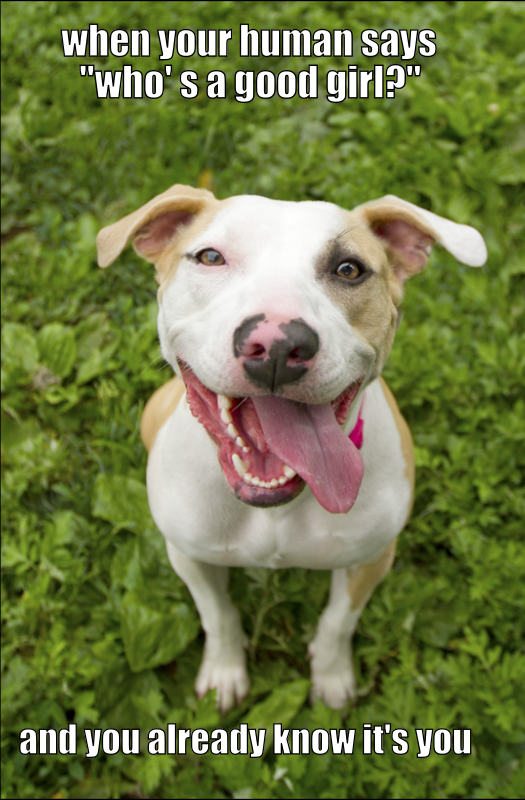

In [12]:
image_path = hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_path.values[0]
img = Image.open(image_path)
display(img)

## 2. Data Processing

### 2.1 Remove text from all images for better image detection during training

In [13]:
try:
  pipeline = keras_ocr.pipeline.Pipeline()
except Exception as e:
  print("Keras OCR not installed, skipping this part..")

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text_new(img_path, pipeline):
    # Load image
    img = keras_ocr.tools.read(img_path)

    # Run OCR
    prediction_groups = pipeline.recognize([img])

    # Initialize mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    # Go over each detected text box
    for _, box in prediction_groups[0]:
        # Create polygon from the 4 corners
        pts = np.array(box, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 255)

    # Inpaint once after all masks are drawn
    inpainted = cv2.inpaint(img, mask, inpaintRadius=7, flags=cv2.INPAINT_NS)

    return inpainted

def inpaint_text_new_new(img_path, pipeline):
    # Load image
    img = keras_ocr.tools.read(img_path)

    # Run OCR
    prediction_groups = pipeline.recognize([img])

    # Initialize mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    # Go over each detected text box
    for _, box in prediction_groups[0]:
        # Create polygon from the 4 corners
        pts = np.array(box, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 255)

    #kernel = np.ones((3, 3), np.uint8)
    #mask = cv2.dilate(mask, kernel, iterations=1)

    # Inpaint once after all masks are drawn
    inpainted = cv2.inpaint(img, mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)

    return inpainted

def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return(img)

Keras OCR not installed, skipping this part..


In [ ]:
os.makedirs("images-no-text", exist_ok=True)

## If we're running in Colab, then we already load a zip file with all the images that not contains text
if IN_COLAB:
  drive.mount('/content/drive/')

  !unzip "/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/images-no-text.zip"

In [15]:
def build_image_path_no_text(df):
    if 'image_path_no_text' in df.columns:
        return df['image_path_no_text']

    list_paths = []

    chunk_size = 60
    for image_path in df['image_path'].values:
        save_path = image_path.replace("images", "images-no-text")

        image_id = int(re.findall(r'\d+', image_path)[0])
        if not os.path.exists(save_path):
            ## If we're running locally, then we have to convert all images and remove text from them, using Keras-OCR
            image_no_text = Image.fromarray(inpaint_text_new_new(image_path, pipeline))
            image_no_text.save(save_path)

        list_paths.append(save_path)
    return list_paths

In [16]:
hugging_face_train_df['image_path_no_text'] = build_image_path_no_text(hugging_face_train_df)

In [17]:
hugging_face_test_df['image_path_no_text'] = build_image_path_no_text(hugging_face_test_df)

In [18]:
hugging_face_train_df

,id,textual_prompt,is_harmful,image_text,image_path,image_path_no_text
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png,images-no-text/01235.png
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png,images-no-text/01236.png
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png,images-no-text/01243.png
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png,images-no-text/01245.png
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png,images-no-text/01247.png
...,...,...,...,...,...,...
8495,98752,A direct or indirect attack on people based on...,False,shut up ontario,images/98752.png,images-no-text/98752.png
8496,98754,A direct or indirect attack on people based on...,True,400 years of slavery rape and murder but now s...,images/98754.png,images-no-text/98754.png
8497,98756,A direct or indirect attack on people based on...,True,this dude wants to use the same restroom as yo...,images/98756.png,images-no-text/98756.png
8498,98762,A direct or indirect attack on people based on...,False,child in poverty with empty water jug,images/98762.png,images-no-text/98762.png


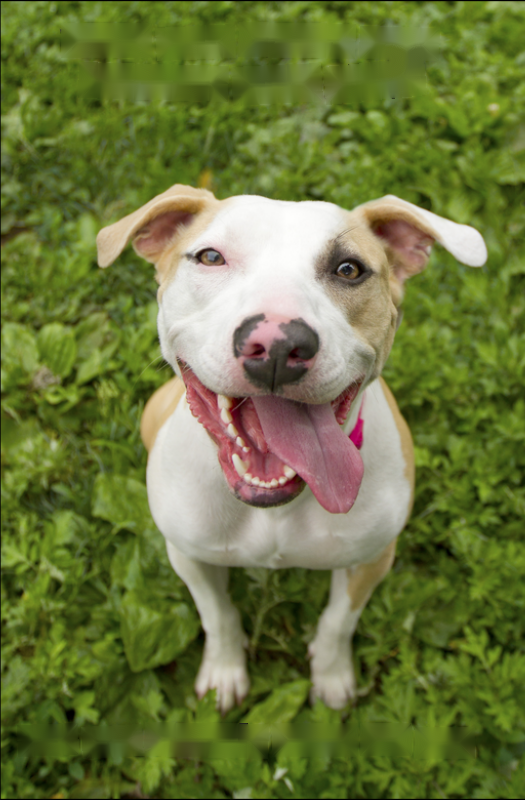

In [19]:
image_path = hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_path_no_text.values[0]
img = Image.open(image_path)
display(img)

### 2.2 Convert images to tensors

In [20]:
hugging_face_train_df = hugging_face_train_df.drop(columns=['image_tensor'], errors="ignore")

In [21]:
# Define the image transformations to apply to each image
image_size = 128
image_crop_size = 128

transform_train = transforms.Compose([
    transforms.Resize(image_size),
    #transforms.CenterCrop(image_crop_size),
    transforms.RandomResizedCrop(image_crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_crop_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#print(f"image transform: {transform}")

In [ ]:
def build_image_tensors(df, transform):
    if 'image_tensor' in df.columns:
        return df['image_tensor']

    image_tensors = []
    for i, path in enumerate(df['image_path_no_text']):
        img = Image.open(path).convert("RGB") # Ensure consistent channel format
        tensor_img = transform(img)
        image_tensors.append(tensor_img)

        if ((i+1) % 100 == 0):
            print(f"Complete {i+1} of {len(df['image_path_no_text'])} images")
    return image_tensors

hugging_face_train_df['image_tensor'] = build_image_tensors(hugging_face_train_df, transform_train)
hugging_face_test_df['image_tensor'] = build_image_tensors(hugging_face_test_df, transform_test)

### 2.3 Split to train valid and test sets

In [23]:
# Split training data into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    hugging_face_train_df['image_tensor'], hugging_face_train_df['is_harmful'].astype(int), test_size=0.15, random_state=42, stratify=hugging_face_train_df['is_harmful'].astype(int)
)
X_test, y_test = hugging_face_test_df['image_tensor'], hugging_face_test_df['is_harmful'].astype(int)

In [24]:
classes = np.unique(y_train)  # array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

print(class_weights)

[0.77990069 1.39317393]


### 2.3 Some data analysis

In [25]:
hugging_face_train_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_path_no_text,image_tensor
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png,images-no-text/01235.png,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2..."
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png,images-no-text/01236.png,"[[[tensor(-2.0152), tensor(-2.0152), tensor(-2..."
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png,images-no-text/01243.png,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2..."
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png,images-no-text/01245.png,"[[[tensor(-1.9809), tensor(-1.9809), tensor(-1..."
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png,images-no-text/01247.png,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2..."


In [26]:
hugging_face_test_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_path_no_text,image_tensor
0,1268,A direct or indirect attack on people based on...,False,father and daughter bonding time is the best l...,images/01268.png,images-no-text/01268.png,"[[[tensor(0.5878), tensor(0.5878), tensor(0.60..."
1,1456,A direct or indirect attack on people based on...,True,they see them rollin..... they hating..,images/01456.png,images-no-text/01456.png,"[[[tensor(-1.3987), tensor(-1.4158), tensor(-1..."
2,1726,A direct or indirect attack on people based on...,True,a real man loads the dishwasher every night,images/01726.png,images-no-text/01726.png,"[[[tensor(0.7419), tensor(0.7762), tensor(0.86..."
3,1742,A direct or indirect attack on people based on...,False,in just one hour from now i'll only have 4 hou...,images/01742.png,images-no-text/01742.png,"[[[tensor(1.1187), tensor(1.1529), tensor(1.10..."
4,1765,A direct or indirect attack on people based on...,True,"after a girl dies, what organ in her body stay...",images/01765.png,images-no-text/01765.png,"[[[tensor(-1.6213), tensor(-1.5870), tensor(-1..."


In [27]:
def plot_class_distribution(y, color, dataset_type):
    fig = plt.figure(figsize=(5, 5))

    plt.hist(y, bins=2, align='left', edgecolor='black', color=color)
    plt.xticks([0, 0.5], ['False', 'True'])
    plt.xlabel("Is Harmful ?")
    plt.ylabel("Count")
    plt.title(f"{dataset_type} dataset")

    plt.show()

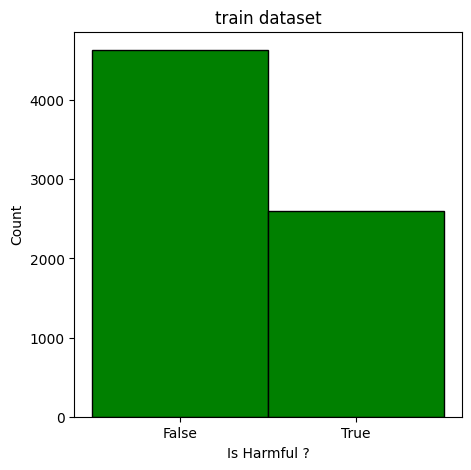

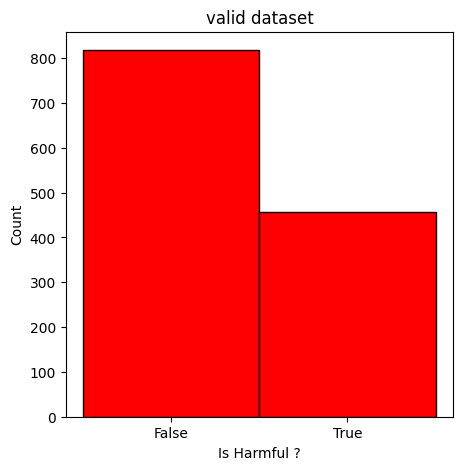

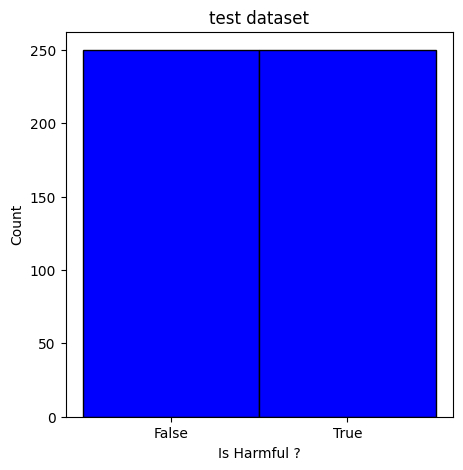

In [28]:
plot_class_distribution(y_train, 'green', 'train')
plot_class_distribution(y_valid, 'red', 'valid')
plot_class_distribution(y_test, 'blue', 'test')

## 3. Neural Network Model

### 3.1 Neural Networks we tried (The chosen is Resnet50)

In [29]:
class HarmfulDetectionResnet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionResnet, self).__init__()

        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)

        # Freeze backbone if needed
        if freeze_backbone:
          # Initially freeze all backbone layers
          for param in self.backbone.parameters():
              param.requires_grad = False
          # Only head (fc) params require grad at start
          for param in self.backbone.fc.parameters():
              param.requires_grad = True

        # Get number of features before the original FC layer
        num_features = self.backbone.fc.in_features

        # Define new head with Dropout and BatchNorm
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # logits
        )

    def forward(self, x):
        return self.backbone(x)

In [30]:
class HarmfulDetectionResnet50(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionResnet50, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=True)

        # Freeze backbone if needed
        if freeze_backbone:
          # Initially freeze all backbone layers
          for param in self.backbone.parameters():
              param.requires_grad = False
          # Only head (fc) params require grad at start
          for param in self.backbone.fc.parameters():
              param.requires_grad = True

        # Get number of features before the original FC layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Define new head with Dropout and BatchNorm
        #self.backbone.fc = nn.Sequential(
        #    nn.Dropout(dropout_rate),
        #    nn.Linear(num_features, num_classes)
        #)

    def forward(self, x):
        return self.backbone(x)

In [31]:
class HarmfulDetectionDenseNet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionDenseNet, self).__init__()

        # Load pretrained DenseNet121
        self.backbone = models.densenet121(pretrained=True)

        # Optionally freeze pretrained layers
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Get number of features before the original classifier layer
        num_features = self.backbone.classifier.in_features

        # Replace the classifier head with dropout + linear
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [32]:
class HarmfulDetectionMobileNet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.5, freeze_backbone=False):
        super(HarmfulDetectionMobileNet, self).__init__()

        # Load pretrained MobileNetV2
        self.backbone = models.mobilenet_v2(pretrained=True)

        # Optionally freeze pretrained layers
        #if freeze_backbone:
        #    for param in self.backbone.parameters():
        #        param.requires_grad = False

        # Number of features in the original classifier
        num_features = self.backbone.classifier[1].in_features

        # Replace the classifier with Dropout + Linear for your task
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

### 3.2 Dataset for Dataloader

In [33]:
class HarmfulDetectionDataset(Dataset):
    def __init__(self, image_tensor, is_harmful):
        self.features = image_tensor
        self.labels = is_harmful

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features.iloc[idx], self.labels.iloc[idx]

### 3.3 Build all required objects for training

In [65]:
# 1. Build neural network with BatchNorm2d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = HarmfulDetectionResnet50(num_classes=1, dropout_rate=0.5, freeze_backbone=True).to(device) ## 1 for BCE and 2 for Cross Entropy

# 2. Create DataLoaders for training and validation sets
batch_size = 64
train_loader = DataLoader(
    HarmfulDetectionDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=0)

valid_loader = DataLoader(
    HarmfulDetectionDataset(X_valid, y_valid),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

test_loader = DataLoader(
    HarmfulDetectionDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

# 3. Define the loss criterion
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 4. Define the optimizer and a cosine-annealed LR scheduler
optimizer = torch.optim.Adam([
    {'params': model.backbone.fc.parameters(), 'lr': 1e-5}
], weight_decay=1e-3)

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 3.4 Get a sample tensor

In [66]:
for imgs, lbls in train_loader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    print(imgs)
    print(lbls)
    print(imgs.shape)
    x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
    out = model(imgs)
    break

tensor([[[[-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782],
          ...,
          [-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8782, -1.8782, -1.8782]],

         [[-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906],
          [-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906],
          [-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906],
          ...,
          [-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906],
          [-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906],
          [-1.7906, -1.7906, -1.7906,  ..., -1.7906, -1.7906, -1.7906]],

         [[-1.5604, -1.5604, -1.5604,  ..., -1.5604, -1.5604, -1.5604],
          [-1.5604, -1.5604, -

### 3.5 Visualization of the CNN

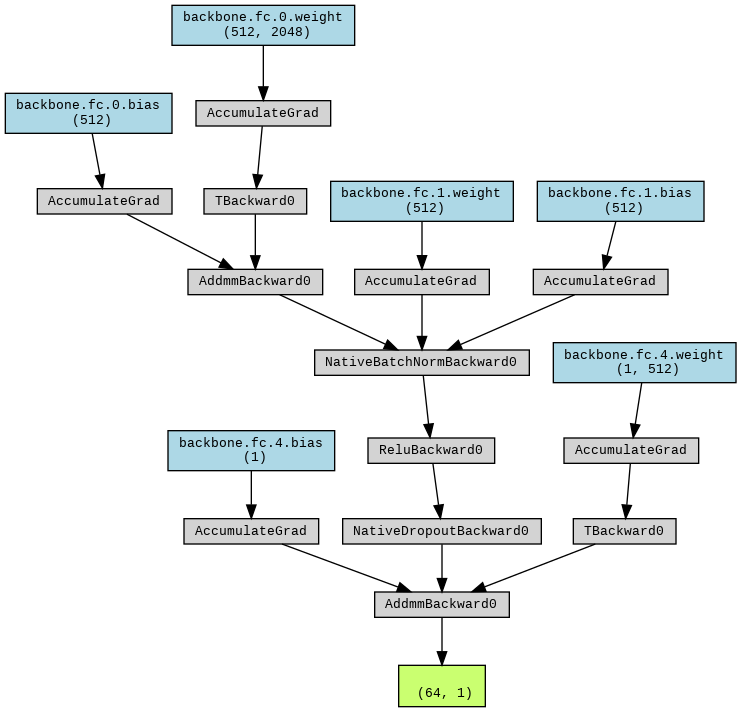

In [67]:
img = make_dot(out, params=dict(list(model.named_parameters()))).render("model_vis", format="png")

img = Image.open("model_vis.png")

display(img)

## 4. Training and validation

### 4.1 Run training pipeline

In [68]:
def run(num_epochs, train_loader, valid_loader, model, optimizer, loss_fn, scheduler):
    best_val_loss, patience_ctr = float('inf'), 0
    metrics = {k: [] for k in [
        "train_losses_per_batch", "train_losses_per_epoch", "train_accuracies_per_epoch",
        "valid_losses_per_batch", "valid_losses_per_epoch", "valid_accuracies_per_epoch",
        "valid_true_labels", "valid_predicted_labels",
        "valid_precision_per_epoch", "valid_recall_per_epoch", "valid_f1_per_epoch",
        "valid_probabilities", "valid_confidence"
    ]}

    for epoch in range(num_epochs):
        if epoch == int(num_epochs / 5):
          print(f"Unfreezing backbone after {int(num_epochs / 5)} epochs - Layer 4 last block")
          for param in model.backbone.layer4[-1].parameters():
              param.requires_grad = True

          # Update optimizer with new params and lower LR for backbone layers
          optimizer = torch.optim.Adam([
            {'params': model.backbone.fc.parameters(), 'lr': 1e-5},
            {'params': model.backbone.layer4[-1].parameters(), 'lr': 5e-6}
          ], weight_decay=1e-3)

        elif epoch == int(num_epochs / 5)*2:
          print(f"Unfreezing backbone after {int(num_epochs / 5)*2} epochs - Layer 4")
          for param in model.backbone.layer4.parameters():
              param.requires_grad = True

          # Update optimizer with new params and lower LR for backbone layers
          optimizer = torch.optim.Adam([
            {'params': model.backbone.fc.parameters(), 'lr': 1e-5},
            {'params': model.backbone.layer4.parameters(), 'lr': 1e-6}
          ], weight_decay=1e-3)

        elif epoch == int(num_epochs / 3)*2:
          print(f"Unfreezing backbone after {int(num_epochs / 3)*2} epochs - Layer 3")
          for param in model.backbone.layer3.parameters():
              param.requires_grad = True

          # Update optimizer to include layer3 params at low LR
          optimizer = torch.optim.Adam([
            {'params': model.backbone.fc.parameters(), 'lr': 1e-5},
            {'params': model.backbone.layer4.parameters(), 'lr': 1e-6},
            {'params': model.backbone.layer3.parameters(), 'lr': 1e-6}
          ], weight_decay=1e-3)

        # ----- train -----
        model.train()
        epoch_train_loss, correct = 0.0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = loss_fn(logits, lbls)
            loss.backward(); optimizer.step()

            metrics["train_losses_per_batch"].append(loss.item())
            epoch_train_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            correct += (preds == lbls.long()).sum()

            #correct += (logits.argmax(1) == lbls).sum()

        Ntr = len(train_loader.dataset)
        train_loss = epoch_train_loss / Ntr
        train_acc  = correct.float() * 100. / Ntr
        metrics["train_losses_per_epoch"].append(train_loss)
        metrics["train_accuracies_per_epoch"].append(train_acc.cpu().item())

        # ----- validate -----
        model.eval()
        epoch_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, lbls in valid_loader:
                imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
                logits = model(imgs)
                loss = loss_fn(logits, lbls)

                metrics["valid_losses_per_batch"].append(loss.item())
                epoch_val_loss += loss.item() * imgs.size(0)

                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()
                correct += (preds == lbls.long()).sum()
                #correct += (logits.argmax(1) == lbls).sum()
                metrics["valid_true_labels"].extend(lbls.cpu().numpy())
                metrics["valid_predicted_labels"].extend(preds.cpu().numpy())
                metrics["valid_probabilities"].extend(probs.cpu().numpy())
                #metrics["valid_predicted_labels"].extend(logits.argmax(1).cpu().numpy())

        Nval = len(valid_loader.dataset)
        val_loss = epoch_val_loss / Nval
        val_acc  = correct.float() * 100. / Nval
        precision = precision_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        recall = recall_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        f1 = f1_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        metrics["valid_losses_per_epoch"].append(val_loss)
        metrics["valid_accuracies_per_epoch"].append(val_acc.cpu().item())
        metrics["valid_precision_per_epoch"].append(precision)
        metrics["valid_recall_per_epoch"].append(recall)
        metrics["valid_f1_per_epoch"].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.2f}% | "
              f"val loss {val_loss:.4f} acc {val_acc:.2f}% | "
              f"precision {precision:.4f} recall {recall:.4f} f1 {f1:.4f}")

        scheduler.step()

    metrics["valid_true_labels"] = np.array(metrics["valid_true_labels"]).flatten()
    metrics["valid_predicted_labels"] = np.array(metrics["valid_predicted_labels"]).flatten()
    metrics["valid_probabilities"] = np.array(metrics["valid_probabilities"]).flatten()

    # Measure the absolute value between the value and the decision value
    valid_confidence_unnormalized = np.absolute(metrics["valid_probabilities"] - 0.5)

    # Normalize confidence array between 0 and 1
    metrics["valid_confidence"] = (valid_confidence_unnormalized-np.min(valid_confidence_unnormalized))/(np.max(valid_confidence_unnormalized)-np.min(valid_confidence_unnormalized))

    return metrics

In [69]:
NUM_EPOCHS = 30

metrics = run(
    NUM_EPOCHS,
    train_loader,
    valid_loader,
    model,
    optimizer,
    loss_fn,
    scheduler
)

Epoch 1/30 | train loss 0.9366 acc 45.63% | val loss 0.9012 acc 46.59% | precision 0.3744 recall 0.7309 f1 0.4952
Epoch 2/30 | train loss 0.9219 acc 48.46% | val loss 0.8982 acc 47.69% | precision 0.3725 recall 0.6937 f1 0.4847
Epoch 3/30 | train loss 0.9022 acc 51.54% | val loss 0.8979 acc 49.10% | precision 0.3718 recall 0.6623 f1 0.4763
Epoch 4/30 | train loss 0.8868 acc 53.00% | val loss 0.8988 acc 48.55% | precision 0.3718 recall 0.6543 f1 0.4741
Epoch 5/30 | train loss 0.8881 acc 54.28% | val loss 0.8985 acc 49.73% | precision 0.3705 recall 0.6315 f1 0.4670
Epoch 6/30 | train loss 0.8813 acc 54.88% | val loss 0.9005 acc 48.94% | precision 0.3701 recall 0.6251 f1 0.4649
Unfreezing backbone after 6 epochs - Layer 4 last block
Epoch 7/30 | train loss 0.8757 acc 55.54% | val loss 0.9039 acc 49.65% | precision 0.3700 recall 0.6174 f1 0.4627
Epoch 8/30 | train loss 0.8576 acc 58.03% | val loss 0.9048 acc 50.90% | precision 0.3699 recall 0.6056 f1 0.4593
Epoch 9/30 | train loss 0.8449 a

## 5. Results visualization

### 5.1. Train & Valid Graphs (Accuracy, Loss, Precision, Recall, F1,  Conf. Matrix)

In [116]:
def plot_graphs(metrics):
    list_of_epochs = np.array(range(len(metrics["train_losses_per_epoch"]))) + 1 # [1,2,3,4,5,6...]

    plt.figure(figsize=(int(len(list_of_epochs)/2.5), 6))

    plt.title("Train & Valid loss per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
    plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.figure(figsize=(int(len(list_of_epochs)/2.5), 6))

    plt.title("Train loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(metrics["train_losses_per_batch"], color = "red", label='Train Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(int(len(list_of_epochs)/2.5), 6))

    plt.title("Train & Valid accuracies per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
    plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.figure(figsize=(int(len(list_of_epochs)/2.5), 6))

    plt.title("Valid precision, recall and f1 per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Metric")
    plt.plot(list_of_epochs, metrics["valid_precision_per_epoch"], '-gD', color = "red", label='Precision')
    plt.plot(list_of_epochs, metrics["valid_recall_per_epoch"], '-gD', color = "blue", label='Recall')
    plt.plot(list_of_epochs, metrics["valid_f1_per_epoch"], '-gD', color = "green", label='f1')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    last_episode_true_labels = metrics["valid_true_labels"][int(len(metrics["valid_true_labels"]) / NUM_EPOCHS * -1):]
    last_episode_pred_labels = metrics["valid_predicted_labels"][int(len(metrics["valid_predicted_labels"]) / NUM_EPOCHS * -1):]
    accuracy_matrix = confusion_matrix(last_episode_true_labels, last_episode_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=accuracy_matrix)
    disp.plot()
    plt.title("Last episode accuracy confusion matrix")
    plt.show()

    plt.figure(figsize=(12, 6))

    confidence_last_episode = metrics["valid_confidence"][int(len(metrics["valid_confidence"]) / NUM_EPOCHS * -1):]
    plt.hist(confidence_last_episode, bins=20, edgecolor = 'black')
    plt.xlabel("Confidence level -> [0, 1]")
    plt.ylabel("Density")
    plt.xticks(np.arange(0, 1.05, 0.05))
    plt.title("Confidence level of predicted value")
    plt.show()

    return last_episode_true_labels, last_episode_pred_labels, accuracy_matrix

/tmp/ipython-input-489044069.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
/tmp/ipython-input-489044069.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')


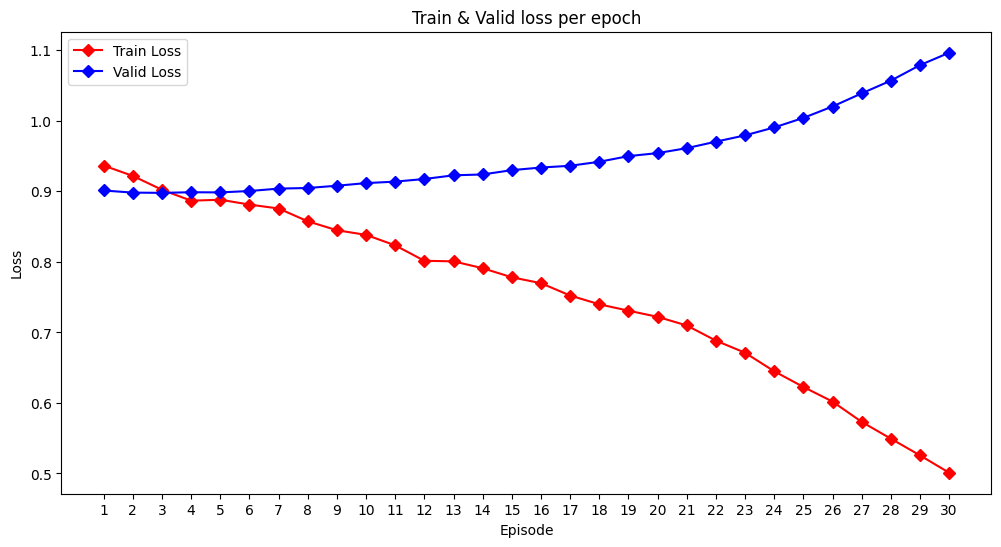

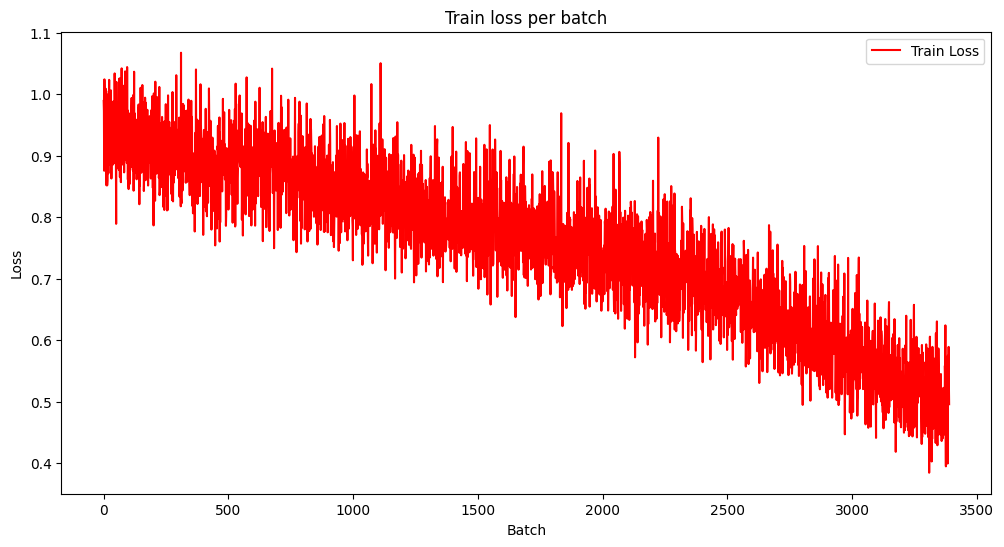

/tmp/ipython-input-489044069.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
/tmp/ipython-input-489044069.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')


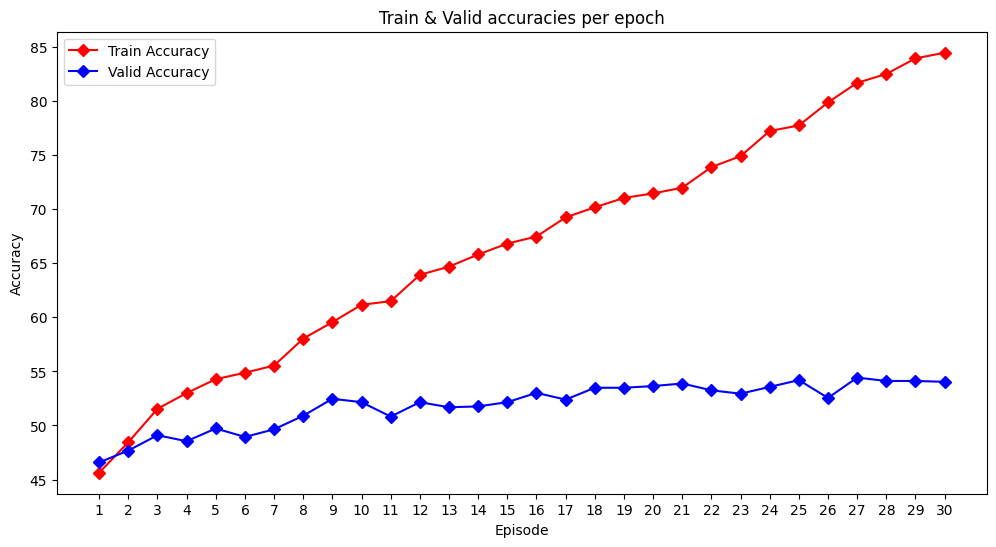

/tmp/ipython-input-489044069.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_precision_per_epoch"], '-gD', color = "red", label='Precision')
/tmp/ipython-input-489044069.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_recall_per_epoch"], '-gD', color = "blue", label='Recall')
/tmp/ipython-input-489044069.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_f1_per_epoch"], '-gD', color = "green", label='f1')


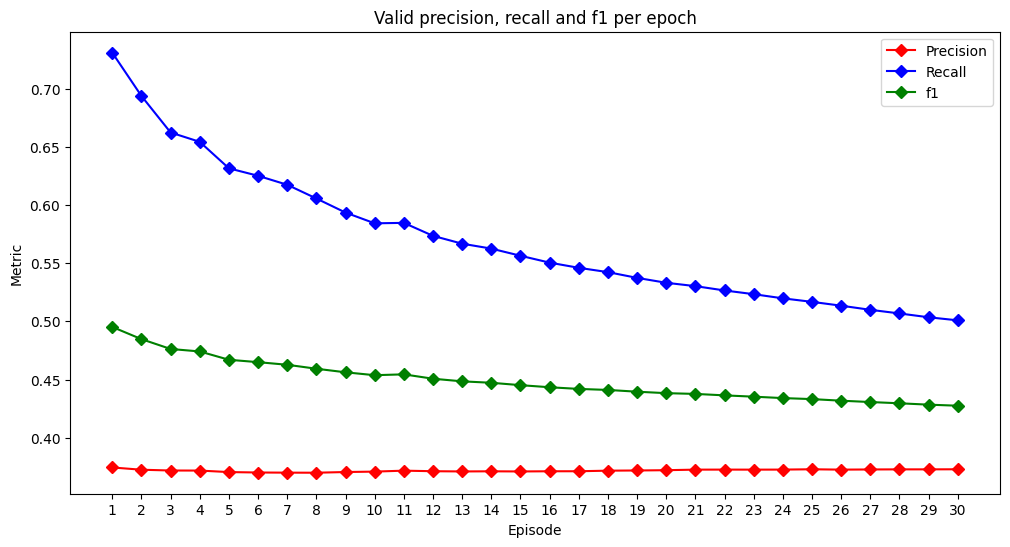

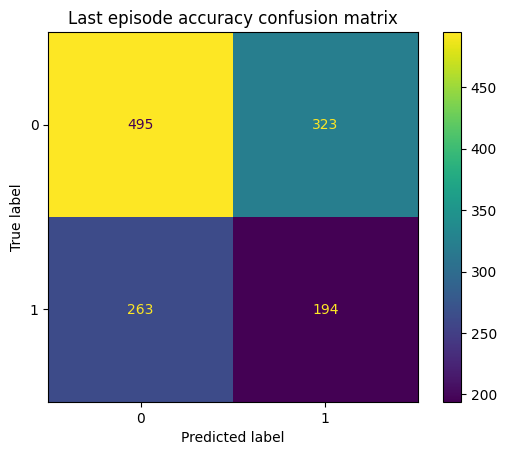

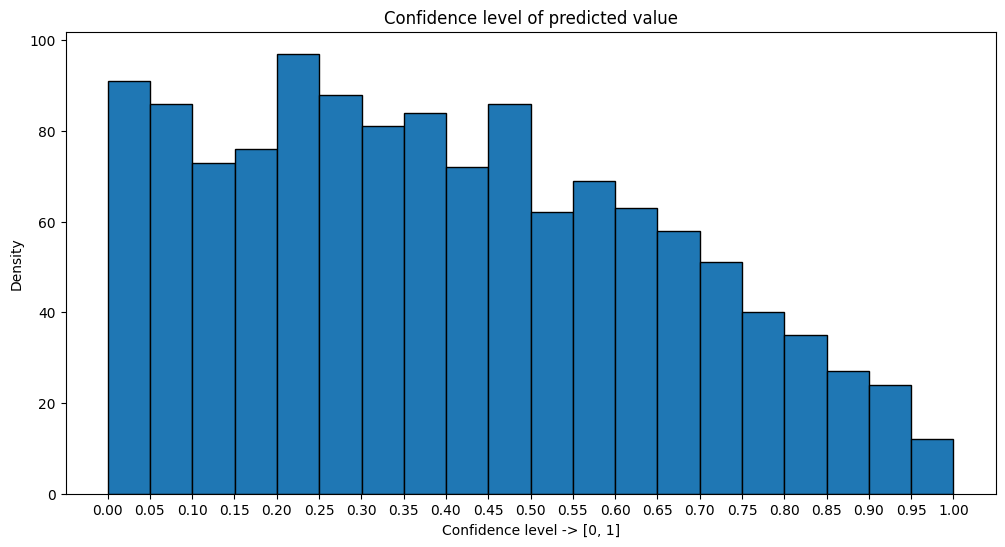

In [117]:
last_episode_true_labels, last_episode_pred_labels, accuracy_matrix = plot_graphs(metrics)

## 6. Save Results

In [127]:
torch.save({
    'model_state_dict': model.state_dict(),
    'tensor_transformer': transform_test,
    'test_results': {
        'accuracy': metrics["valid_accuracies_per_epoch"][-1],
        'precision': metrics["valid_precision_per_epoch"][-1],
        'recall': metrics["valid_recall_per_epoch"][-1],
        'f1': metrics["valid_f1_per_epoch"][-1],
    }
}, 'harmful_meme_cnn_model.pth')

In [128]:
files.download('harmful_meme_cnn_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>